In [2]:
import xarray as xr

In [43]:
ds = xr.open_dataset('~/projects/crocus/data/IOP/W09E_2024-07-27_00.nc')
df = ds.to_dataframe()
df.head()

,temp,uwind,vwind,wwind
time,,,,
2024-07-27 00:00:00.021,23.666000,-1.677,-0.222,-0.576
2024-07-27 00:00:00.054,23.650999,-1.920,-0.116,-0.454
2024-07-27 00:00:00.087,23.645000,-2.281,0.142,-0.035
2024-07-27 00:00:00.120,23.705999,-2.578,0.167,0.071
2024-07-27 00:00:00.153,NaN,-2.612,-0.062,NaN


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

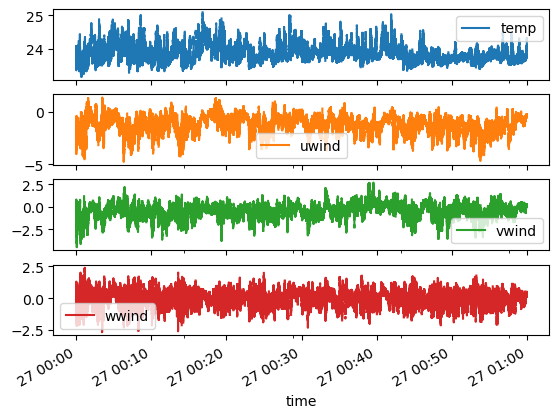

In [44]:
df.plot.line(y=['temp', 'uwind', 'vwind', 'wwind'], subplots=True)

<Axes: ylabel='Frequency'>

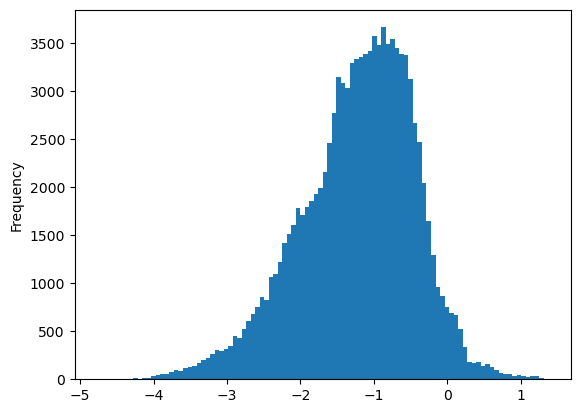

In [46]:
df['uwind'].plot.hist(bins=100)

# Run to download the data 

In [ ]:
import sage_data_client
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime

# Define the date, sensor VSN, and output directory
date = "2024-07-27"
vsn = "W09E"
plugin = "10.31.81.1:5000/local/plugin-metek-sonic3d-sampler"
out_dir = "/Users/bhupendra/projects/crocus/data/IOP/"

# Define global metadata attributes
global_attrs = {
    "site_name": "ADM",
    "altitude": "185",
    "latitude": "",
    "longitude": "",
    "station_name": "CROCUS",
    "acquisition_frequency": "20.0",  # Hz
    "instr_1_manufacturer": "metek",
    "instr_1_model": "usoni3_classa_mp_1",
    "data_contact": "Bhupendra Raut <braut@anl.gov>",
    "inst_contact": "Sujan Pal <spal@anl.gov>",
    "source": "CROCUS Measurement Strategy Team",
    "project": "Community Research on Climate and Urban Science (CROCUS) - an Urban Integrated Field Laboratory",
    "data_policy": "Open data, adheres to FAIR principles (Findable, Accessible, Interoperable, Reusable)",
    "institution": "Argonne National Laboratory",
    "funding_source": "U.S. DOE Office of Science, Biological and Environmental Research program",
    "acknowledgment": (
        "This material is based upon work supported by the U.S. Department of Energy, "
        "Office of Science, Office of Biological and Environmental Research’s Urban Integrated "
        "Field Laboratories CROCUS project research activity, under Contract Number DE-AC02-06CH11357 "
        "and Award Number DE-SC0023226."
    ),
    "file_creation_date": datetime.now().replace(tzinfo=None).strftime("%Y-%m-%d"),
    "data_version": "v1.0.0",
    "file_version": "2025.02.10",
}

for hour in range(24):
    start_time = f"{date}T{hour:02d}:00:00Z"
    end_time = f"{date}T{hour:02d}:59:59Z"

    # Query data for the hour
    df = sage_data_client.query(start=start_time, end=end_time, filter={"vsn": vsn, "plugin": plugin})

    if df.empty:
        print(f"No data found for {start_time} - Skipping...")
        exit()  # Exit if no data

    # Convert timestamp to CF-compliant format (nanoseconds since 1970-01-01)
    time_base = pd.Timestamp("1970-01-01T00:00:00", tz="UTC")

    # Ensure timestamps are timezone-aware
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Round timestamps to the nearest 2 milliseconds (2000 µs) to align high-frequency data
    df["rounded_timestamp"] = df["timestamp"].dt.round("3000us")

    # Clean variable names (remove "sonic3d.")
    df["name"] = df["name"].str.replace("sonic3d.", "", regex=False)

    # Pivot after rounding timestamps
    df_pivot = df.pivot(columns="name", values="value")

    # Group by rounded timestamps and aggregate using mean() (averages multiple readings)
    df_pivot = df_pivot.groupby(df["rounded_timestamp"]).mean()

    # Reset index and rename "rounded_timestamp" to "time"
    df_pivot = df_pivot.reset_index().rename(columns={"rounded_timestamp": "time"})

    # Convert time to nanoseconds since epoch (int64)
    df_pivot["time"] = (df_pivot["time"] - time_base).astype("int64")

    # Extract metadata
    metadata = df.drop_duplicates(subset=["name"]).set_index("name")["meta.description"].to_dict()
    units = df.drop_duplicates(subset=["name"]).set_index("name")["meta.units"].to_dict()

    # Create Xarray Dataset
    ds = xr.Dataset()

    # Add time variable (CF-compliant format)
    ds["time"] = ("time", df_pivot["time"].values.astype(np.int64))  # Store as int64 nanoseconds
    ds["time"].attrs["units"] = "nanoseconds since 1970-01-01 00:00:00 UTC"
    ds["time"].attrs["long_name"] = "Time in nanoseconds since epoch"
    ds["time"].attrs["standard_name"] = "time"

    # Add sensor variables
    for var in df_pivot.columns.drop(["time"], errors="ignore"):
        ds[var] = ("time", df_pivot[var].values.astype(np.float32))
        ds[var].attrs["description"] = metadata.get(var, "No description available")
        ds[var].attrs["units"] = units.get(var, "Unknown")

    # Add global attributes
    ds.attrs.update(global_attrs)

    # Save to NetCDF
    filename = f"{out_dir}{vsn}_{date}_{hour:02d}.nc"
    ds.to_netcdf(filename, format="NETCDF4", engine="netcdf4")

    print(f"Saved {filename}")
print("Processing complete!")


Saved /Users/bhupendra/projects/crocus/data/IOP/W09E_2024-07-27_00.nc
Processing complete!
